# Reinforcement Learning

## Cartpole solution with policy gradient

Установим и импортируем необходимые библиотеки, а также вспомогательные функции для визуализации игры агента.

In [0]:
!pip install gym pandas torch matplotlib pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [0]:
from IPython.display import clear_output, HTML
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import numpy as np
import glob
import time
import io
import base64
import gym
from gym.wrappers import Monitor
import torch
import collections
import pandas as pd
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Categorical

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #позволяет перенести тензор на GPU, если он доступен в системе

## OpenAI Gym

In [0]:
env = gym.make("CartPole-v0")
print(env.env.__doc__)


    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson

    Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
        
    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gra

In [0]:
def test_agent(env, agent=None, n_episodes=100):
    """Runs agent for n_episodes in environment and calclates mean reward.
    
    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
        Mean reward for 100 episodes.
    """
    total_reward = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if agent:
                with torch.no_grad():
                    probs = agent(torch.FloatTensor(observation).to(device))
                    dist = Categorical(probs)
                    action = dist.sample().item()
            else:
                action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
        env.close()
                   
    return np.mean(total_reward)

In [0]:
test_agent(env, agent=False, n_episodes=10)

Episode 1 finished after 22 timesteps
Episode 2 finished after 31 timesteps
Episode 3 finished after 29 timesteps
Episode 4 finished after 12 timesteps
Episode 5 finished after 30 timesteps
Episode 6 finished after 19 timesteps
Episode 7 finished after 14 timesteps
Episode 8 finished after 18 timesteps
Episode 9 finished after 21 timesteps
Episode 10 finished after 59 timesteps


24.5

In [0]:
def agent_viz(env="CartPole-v0", agent=None):
    """Visualizes agent play in the given environment.
    
    Args:
        env: The environment for agent to play in. Defaults to CartPole-v0.
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.

    Returns:
        Nothing is returned. Visualization is created and can be showed
            with show_video() function.
    """
    env = wrap_env(gym.make(env))
    observation = env.reset()
    while True:
        env.render() 
        if agent:
            with torch.no_grad():
                probs = agent(torch.FloatTensor(observation).to(device))
                dist = Categorical(probs)
                action = dist.sample().item()
        else:
            action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            break
            
    env.close()

In [0]:
agent_viz()
show_video()

## REINFORCE

<img src="//i.imgur.com/bnASTrY.png" width="700">

1. Инициализуем политику (в качестве политики мы будем использовать глубокую нейронную сеть).
2. "Играем" в среде эпизод, используя нашу политику, или несколько (мы будем использовать последний вариант) и собираем данные о состояниях, действиях и полученных наградах. 
3. Для каждого состояния в собранных эпизодах вычисляем сумму дисконтированных наград, полученных из этого состояния, а также логорифм правдоподобия предпринятого действия в этом состоянии для нашей политики.
4. Обновляем параметры нашей политики по формуле на схеме.

### Политика

Политика должна принимать на вход состояние среды, а на выходе выдавать распределение по действиям, которые мы можем осуществлять в среде.


In [0]:
class Policy(nn.Module):
    """Policy to be used by agent.

    Attributes
    
    state_size: Dimention of the state space of the environment.
    act_size: Dimention of the action space of the environment.
    hidden_size: Dimention of the hidden state of the agent's policy.
    """
    def __init__(self, state_size, act_size, hidden_size):
        super(Policy, self).__init__()
        self.fc_1 = nn.Linear(state_size, hidden_size, bias=False)
        self.fc_2 = nn.Linear(hidden_size, act_size, bias=False)


    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.softmax(self.fc_2(x))
        return x


### Оценка правдоподобия и расчет суммы дисконтированных наград


In [0]:
def process_traj_batch(policy, batch, discount):
    """Computes log probabilities for each action 
        and rewards-to-go for each state in the batch of trajectories.
    
    Args:
        policy: Policy of the agent.
        batch (list of list of collections.namedtuple): Batch of trajectories.
        discount (float): Discount factor for rewards-to-go calculation.

    Returns:
        log_probs (list of torch.FloatTensor): List of log probabilities for
            each action in the batch of trajectories.
        returns (list of rewards-to-go): List of rewards-to-go for 
            each state in the batch of trajectories.
    """
    policy = policy.to(device)
    log_probs = []
    returns = []
    
    for i in range(len(batch)):
        for j in range(len(batch[i])):
            # calc log prob
            cur_state, cur_action = batch[i][j].state, batch[i][j].action
            cur_state = torch.FloatTensor(cur_state).to(device)
            prob_act = torch.log(policy(cur_state)[cur_action])
            log_probs.append(prob_act)

            # calc reward-to-go
            rollout_rewards = [transition.reward for transition in batch[i][j:]]
            r_n = 0
            for r in range(len(rollout_rewards)):
                if r == 0:
                    r_n += rollout_rewards[r]
                else:
                    r_n += discount**r*rollout_rewards[r]
            returns.append(r_n)

    return log_probs, returns

In [0]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [0]:
STATE_SIZE  = env.observation_space.shape[0] # размерность пространства состояний среды
ACT_SIZE = env.action_space.n # размерность пространства действий среды
HIDDEN_SIZE = 256 # размер скрытого слоя для политики
NUM_EPISODES = 200 # количество эпиздов, которые будут сыграны для обучения
DISCOUNT = 0.99 # фактор дисконтирования
TRAIN_EVERY = 40

In [0]:
policy = Policy(STATE_SIZE, ACT_SIZE, HIDDEN_SIZE).to(device)
optimizer = Adam(policy.parameters())

In [0]:
transition = collections.namedtuple("transition", ["state", "action", "reward"])

### Основной цикл обучения


1. Играем количество эпизодов, определенное в гиперпараметре ```NUM_EPISODES```.
2. В каждом эпизоде сохраняем информацию о шагах на траектории - состояние, действие и награду.
3. В конце каждого эпизода сохраняем вышеуказанную информацию о траектории. 
4. Периодически обучаемся на собранных эпизодах каждые ```TRAIN_EVERY``` эпизодов:  
    4.1. Считаем для собранного батча для каждого шага на трактории правдоподобие и сумму дисконтированных наград.  
    4.2. Обновляем параметры политики агента по формуле, приведенной на схеме.

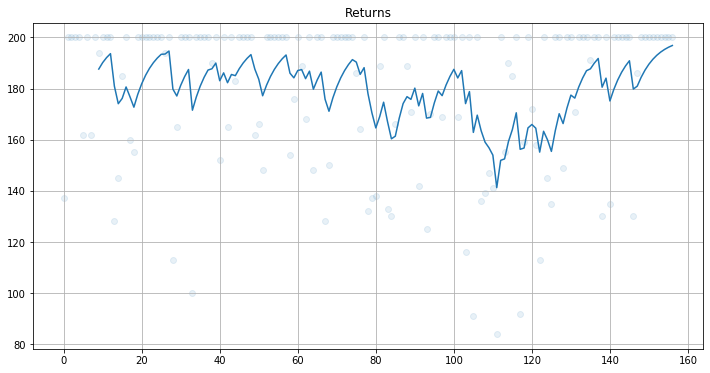

In [0]:
returns_history = []
traj_batch = []

for i in range(NUM_EPISODES):

    state = env.reset()
    rewards = 0
    traj = []
    while True:

        transition = collections.namedtuple("transition", ["state", "action", "reward"])
        transition.state = state

        probs = policy(torch.FloatTensor(state).to(device))
        dist = Categorical(probs)
        action = dist.sample()
        transition.action = action

        state, reward, done, info = env.step(action.item())
        transition.reward = reward

        rewards += reward

        traj.append(transition)

        if done:
            break
    env.close()

    returns_history.append(rewards)
    traj_batch.append(traj)

    if i % TRAIN_EVERY:
        log_probs, returns = process_traj_batch(policy, traj_batch, DISCOUNT)
        loss = -(torch.stack(log_probs) * torch.FloatTensor(returns).to(device)).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        traj_batch = []

    if i % 20:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.title('Returns'); plt.grid()
        plt.scatter(np.arange(len(returns_history)), returns_history, alpha=0.1)
        ma = moving_average(returns_history, span=10, min_periods=10)
        plt.plot(ma)
        plt.show()
    if np.mean(returns_history[-10:]) >= env.spec.reward_threshold:
        break

Протестируем обученного агента.

In [0]:
test_agent(env, agent=policy, n_episodes=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 1 finished after 156 timesteps
Episode 2 finished after 201 timesteps
Episode 3 finished after 201 timesteps
Episode 4 finished after 188 timesteps
Episode 5 finished after 185 timesteps
Episode 6 finished after 201 timesteps
Episode 7 finished after 201 timesteps
Episode 8 finished after 201 timesteps
Episode 9 finished after 201 timesteps
Episode 10 finished after 201 timesteps


192.6

In [0]:
agent_viz(agent=policy)
show_video()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
